In [1]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date

import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/" + \
           "10_intersect_Grant_Irr_2008_2018_2cols/"

L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_102008-01-01_2012-05-05.csv")
L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_10_2008-01-01_2021-09-23.csv")
L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_10_2008-01-01_2021-10-14.csv")

In [3]:
# data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/"

# L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_intGrant_2008-01-01_2012-05-05.csv")
# L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_intGrant_2008-01-01_2021-09-23.csv")
# L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_intGrant_2008-01-01_2021-10-14.csv")

In [4]:
L8.head(2)

,ID,NDVI,EVI,system_start_time
0,i57244,NaN,NaN,NaN
1,i62339,NaN,NaN,NaN


In [5]:
indeks = "EVI"

if indeks == "NDVI":
    NoVI = "EVI"
else:
    NoVI = "NDVI"
    
IDcolName = "ID"

In [6]:
L5.drop([NoVI], axis=1, inplace=True)
L5 = L5[L5[indeks].notna()]

L7.drop([NoVI], axis=1, inplace=True)
L7 = L7[L7[indeks].notna()]

L8.drop([NoVI], axis=1, inplace=True)
L8 = L8[L8[indeks].notna()]
L8.head(2)

,ID,EVI,system_start_time
28100,i27636,0.241194,1.364238e+12
28101,i47765,0.167561,1.364238e+12


In [7]:
IDs = np.sort(L5[IDcolName].unique())
L578 = pd.concat([L5, L7, L8])
L578.head(2)

,ID,EVI,system_start_time
42144,i57244,0.222482,1.204396e+12
42145,i62339,0.074632,1.204396e+12


In [8]:
del(L5, L7, L8)
L578 = nc.add_human_start_time_by_system_start_time(L578)

In [9]:
# i27373
a_field = L578.loc[L578.ID == "i17302", ].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
a_field.reset_index(drop=True, inplace=True)

### pre-processing

In [10]:
a_field = nc.initial_clean(df = a_field, column_to_be_cleaned = indeks)
a_field.drop(["system_start_time"], axis=1, inplace=True)
a_field.head(2)

,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


In [11]:
print (a_field[indeks].min())
print (a_field[indeks].max())

-1.5
1.5


# Remove/Interpolate Outliers

In [12]:
noOutlier = nc.interpolate_outliers_EVI_NDVI(outlier_input=a_field, given_col=indeks)
print (noOutlier.shape)
noOutlier.head(2)

(685, 3)


,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


In [13]:
print (noOutlier[indeks].min())
print (noOutlier[indeks].max())
noOutlier.equals(a_field)

-0.2236942112573014
0.9547879015211858


False

# Correct Big Jumps

In [14]:
NoJump = nc.correct_big_jumps_1DaySeries(dataTMS_jumpie = noOutlier, 
                                         give_col = indeks, 
                                         maxjump_perDay = 0.018)

NoJump.head(2)

i17302


,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


In [15]:
NoJump.tail(2)

,ID,EVI,human_system_start_time
683,i17302,0.339338,2021-09-21
684,i17302,0.314434,2021-10-06


# Regularize

In [16]:
regular_window_size = 10
regular = nc.regularize_a_field(a_df = NoJump, \
                                V_idks = indeks, \
                                interval_size = regular_window_size,\
                                start_year=2008, \
                                end_year=2021)

In [17]:
regular = nc.fill_theGap_linearLine(a_regularized_TS=regular, V_idx=indeks)

In [18]:
# all_years = np.arange(start_year, end_year+1)
# leapyear_count = np.sum([is_leap_year(item) for item in all_years])
# total_no_days = (leapyear_count*366) + ((end_year - start_year + 1 - leapyear_count)*365)
# total_no_points = total_no_days//interval_size
# missing_count = total_no_points - regular_df.shape[0]
# missing_from_beginning = (min(regular_df.human_system_start_time) - \
#                           pd.to_datetime(datetime.datetime(start_year, 1, 1, 0, 0))).days // interval_size

# missing_from_end = missing_count - missing_from_beginning
# print (missing_count)
# print (missing_from_beginning)
# print (missing_from_end)

# missing_begin_df = pd.DataFrame(data = None, 
#                                 index = np.arange(missing_from_beginning), 
#                                 columns = regular_cols)
# missing_begin_df.ID = regular_df.ID.unique()[0]
# mm=min(regular_df.human_system_start_time)
# missing_begin_df[V_idks] = np.array(regular_df[regular_df.human_system_start_time == mm][indeks])[0]
# if "dataset" in regular_cols:
#     missing_begin_df.dataset = regular_df.dataset.unique()[0]

# A = pd.date_range(pd.Timestamp(start_year, 1, 1),
#                    min(regular_df.human_system_start_time),
#                    freq=str(interval_size)+'D')
# missing_begin_df.human_system_start_time = A[:-1]


# missing_end_df = pd.DataFrame(data = None, 
#                               index = np.arange(missing_from_end), 
#                               columns = regular_cols)
# missing_end_df.ID = regular_df.ID.unique()[0]
# mm=max(regular_df.human_system_start_time)
# missing_end_df[V_idks] = np.array(regular_df[regular_df.human_system_start_time == mm][indeks])[0]

# if "dataset" in regular_cols:
#     missing_end_df.dataset = regular_df.dataset.unique()[0]
# regular_df[regular_df.human_system_start_time == mm][indeks]


# np.timedelta64(time_diff, 's').astype(int)

# time_diff.astype(pd.Timedelta)

# time_diff.astype(pd.Timedelta)

# vvv = int(x2) - int(x1) 

# vvv == time_diff.astype(pd.Timedelta)

# print (time_diff)
# np.timedelta64(time_diff, 's').astype(int)

# pd.to_datetime(int(time_vec[left_pointer]))


# SG

In [19]:
SG = scipy.signal.savgol_filter(regular[indeks].values, window_length=7, polyorder=3)
SG[SG > 1 ] = 1 # SG might violate the boundaries. clip them:
SG[SG < -1 ] = -1

In [22]:
SG_df = regular.copy()
SG_df[indeks] = SG
SG_df.head(2)


,ID,human_system_start_time,EVI
0,i17302,2008-01-05,0.123626
1,i17302,2008-01-15,-0.011556


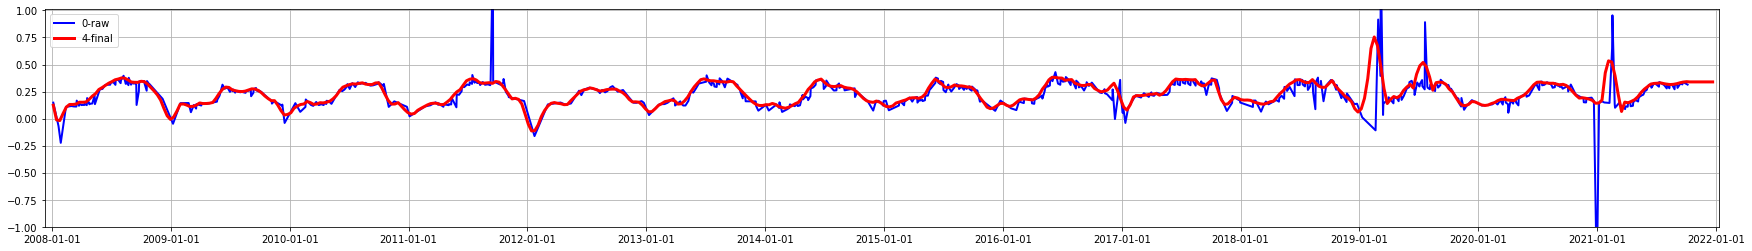

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], 
        a_field['EVI'], 
        '-', linewidth=2, color='b', label = "0-raw")


# ax.scatter(a_field['human_system_start_time'], 
#            a_field['EVI'], 
#            marker='+', linewidth=20, color='b', label = "0-raw")

# ax.plot(noOutlier['human_system_start_time'], 
#         noOutlier['EVI'], 
#         '-', linewidth=2, color='c', label = "1-noOutlier")

# ax.scatter(noOutlier['human_system_start_time'], 
#            noOutlier['EVI'], 
#            marker='+', linewidth=10, color='y', label = "1-noOutlier")

# ax.plot(NoJump['human_system_start_time'], 
#         NoJump['EVI'], 
#         '-', linewidth=5, color='k', label = "2-NoJump")

# ax.scatter(x=NoJump['human_system_start_time'], 
#            y=NoJump['EVI'], 
#            marker='*', linewidth=10, color='k', label = "2-NoJump")

# ax.plot(regular['human_system_start_time'], 
#         regular['EVI'], 
#         '-', linewidth=5, color='g', label = "3-regular")

ax.plot(regular['human_system_start_time'], 
        SG, 
        '-', linewidth=3, color='r', label = "4-final")

xx = datetime.date(2019, 2, 28)
# plt.axvline(x=xx, color="red", label=xx)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.01)
ax.set_xlim([datetime.date(2007, 12, 10), datetime.date(2022, 1, 10)])
# ax.set_xlim([datetime.date(2018, 12, 10), datetime.date(2020, 1, 10)])

plot_dir = "/Users/hn/Desktop/"
file_name = plot_dir + "i17302.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# file_name = plot_dir + "i17302.png"
# plt.savefig(fname = file_name, dpi=100, bbox_inches='tight', transparent=False)

# SOS Detection

In [9]:
raw_df = L578.copy()

In [256]:
yr=2008
indeks = "EVI"

data_dird = "/Users/hn/Documents/01_research_data/NASA/data_deBug/"
a_df = pd.read_csv( data_dird + "04_SG_int_Grant_Irr_2008_2018_EVI_100randomfields.csv", low_memory=False)
a_df['human_system_start_time'] = pd.to_datetime(a_df['human_system_start_time'])
a_df.head(2)

,ID,human_system_start_time,EVI
0,i17302,2008-01-05,0.123626
1,i17302,2008-01-15,-0.011556


In [259]:
ID = a_df.ID.unique()[4]

In [260]:
curr_SG = a_df[a_df['ID'] == ID].copy()
curr_SG.sort_values(by=['human_system_start_time'], inplace=True)
curr_SG.reset_index(drop=True, inplace=True)

curr_raw = raw_df[raw_df['ID'] == ID].copy()
curr_raw.sort_values(by=['human_system_start_time'], inplace=True)
curr_raw.reset_index(drop=True, inplace=True)

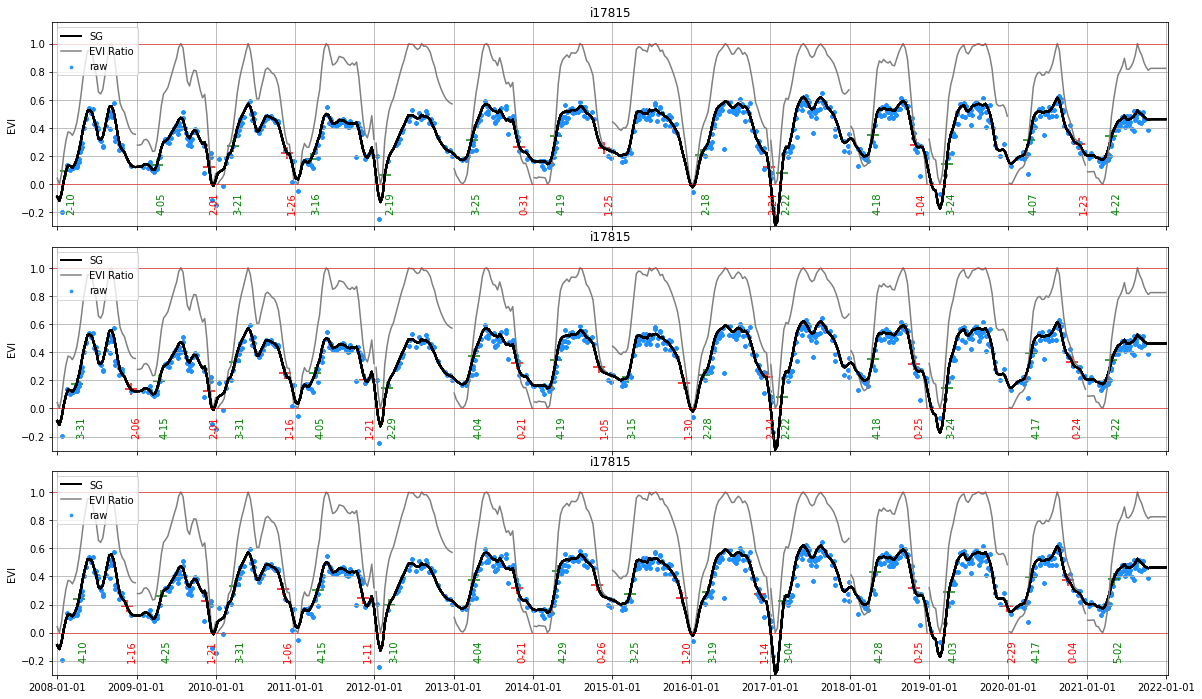

In [261]:
fig, axs = plt.subplots(3, 1, figsize=(20,12),
                            sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0.1, 'wspace': .1});
(ax1, ax2, ax3) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True);

npc.SG_clean_SOS(raw_dt = curr_raw,
                SG_dt = curr_SG,
                idx = indeks,
                ax = ax1,
                onset_cut = 0.3, 
                offset_cut = 0.3);

npc.SG_clean_SOS(raw_dt = curr_raw,
             SG_dt = curr_SG,
             idx = indeks,
             ax = ax2,
             onset_cut = 0.4, 
             offset_cut = 0.4);

npc.SG_clean_SOS(raw_dt = curr_raw,
                 SG_dt = curr_SG,
                idx = indeks,
                ax = ax3,
                onset_cut = 0.5, 
                offset_cut = 0.5);

In [16]:
# pd.to_datetime(datetime.datetime(yr, 5, 1))
# pd.to_datetime(datetime.datetime(yr, 11, 1))

# Find SOS and EOS

In [131]:
raw_dt = curr_raw
SG_dt = curr_SG

In [132]:
SEOS_output_columns = ['ID', indeks, 'human_system_start_time', 
                       'EVI_ratio', 'SOS', 'EOS', 'season_count']

"""
 The reason I am multiplying len(a_df) by 4 is that we can have at least two
 seasons which means 2 SOS and 2 EOS. So, at least 4 rows are needed.
 and the reason for 14 is that there are 14 years from 2008 to 2021.
"""
all_poly_and_SEOS = pd.DataFrame(data = None, 
                                 index = np.arange(4*14*len(a_df)), 
                                 columns = SEOS_output_columns)
unique_years = SG_dt['human_system_start_time'].dt.year.unique()

pointer_SEOS_tab = 0
SG_dt = SG_dt[SEOS_output_columns[0:3]]

"""
  detect SOS and EOS in each year
"""

'\n  detect SOS and EOS in each year\n'

In [133]:
yr = unique_years[1]
yr

2009

In [134]:
for yr in unique_years:
    curr_field_yr = SG_dt[SG_dt['human_system_start_time'].dt.year == yr].copy()

    # Orchards EVI was between more than 0.3
    y_orchard = curr_field_yr[curr_field_yr['human_system_start_time'].dt.month >= 5]
    y_orchard = y_orchard[y_orchard['human_system_start_time'].dt.month <= 10]
    y_orchard_range = max(y_orchard[indeks]) - min(y_orchard[indeks])

    if y_orchard_range > 0.3:

        ### find SOS and EOS, and add them to the table
        curr_field_yr = nc.addToDF_SOS_EOS_White(pd_TS = curr_field_yr, 
                                                 VegIdx = indeks, 
                                                 onset_thresh = onset_cut, 
                                                 offset_thresh = offset_cut)

        ##
        ##  Kill false detected seasons 
        ##
        curr_field_yr = nc.Null_SOS_EOS_by_DoYDiff(pd_TS=curr_field_yr, min_season_length=40)

        #
        # extract the SOS and EOS rows 
        #
        SEOS = curr_field_yr[(curr_field_yr['SOS'] != 0) | curr_field_yr['EOS'] != 0]
        SEOS = SEOS.copy()
        # SEOS = SEOS.reset_index() # not needed really
        SOS_tb = curr_field_yr[curr_field_yr['SOS'] != 0]
        if len(SOS_tb) >= 2:
            SEOS["season_count"] = len(SOS_tb)
            # re-order columns of SEOS so they match!!!
            SEOS = SEOS[all_poly_and_SEOS.columns]
            all_poly_and_SEOS[pointer_SEOS_tab:(pointer_SEOS_tab+len(SEOS))] = SEOS.values
            pointer_SEOS_tab += len(SEOS)
        else:
            # re-order columns of fine_granular_table so they match!!!
            curr_field_yr["season_count"] = 1
            curr_field_yr = curr_field_yr[all_poly_and_SEOS.columns]

            aaa = curr_field_yr.iloc[0].values.reshape(1, len(curr_field_yr.iloc[0]))

            all_poly_and_SEOS.iloc[pointer_SEOS_tab:(pointer_SEOS_tab+1)] = aaa
            pointer_SEOS_tab += 1
    else: 
        """
         here are potentially apples, cherries, etc.
         we did not add EVI_ratio, SOS, and EOS. So, we are missing these
         columns in the data frame. So, use 666 as proxy
        """
        aaa = np.append(curr_field_yr.iloc[0], [666, 666, 666, 1])
        aaa = aaa.reshape(1, len(aaa))
        all_poly_and_SEOS.iloc[pointer_SEOS_tab:(pointer_SEOS_tab+1)] = aaa
        pointer_SEOS_tab += 1
all_poly_and_SEOS = all_poly_and_SEOS[0:(pointer_SEOS_tab)]

In [135]:
all_poly_and_SEOS

,ID,EVI,human_system_start_time,EVI_ratio,SOS,EOS,season_count
0,i17815,-0.089393,2008-01-01 00:00:00,0.041706,-0.0,-0.0,1
1,i17815,0.122881,2009-01-05 00:00:00,666,666,666,1
2,i17815,0.077528,2010-01-10 00:00:00,666,666,666,1
3,i17815,0.041094,2011-01-05 00:00:00,666,666,666,1
4,i17815,0.052969,2012-01-10 00:00:00,666,666,666,1
5,i17815,0.213024,2013-01-04 00:00:00,0.108838,0.0,0.0,1
6,i17815,0.161432,2014-01-09 00:00:00,666,666,666,1
7,i17815,0.232061,2015-01-04 00:00:00,666,666,666,1
8,i17815,-0.022178,2016-01-09 00:00:00,666,666,666,1
9,i17815,-0.008412,2017-01-03 00:00:00,666,666,666,1


In [129]:
aaa = np.append(curr_field_yr.iloc[0], [666, 666, 666, 1])
aaa = aaa.reshape(1, len(aaa))
all_poly_and_SEOS.iloc[pointer_SEOS_tab:(pointer_SEOS_tab+1)] = aaa
pointer_SEOS_tab += 1

In [130]:
all_poly_and_SEOS

,ID,EVI,human_system_start_time,EVI_ratio,SOS,EOS,season_count
0,i17815,0.122881,2009-01-05 00:00:00,666,666,666,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2866523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2866524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2866525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2866526,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for yr in unique_years:
    curr_field_yr = SG_dt[SG_dt['human_system_start_time'].dt.year == yr].copy()

    # Orchards EVI was between more than 0.3
    y_orchard = curr_field_yr[curr_field_yr['human_system_start_time'].dt.month >= 5]
    y_orchard = y_orchard[y_orchard['human_system_start_time'].dt.month <= 10]
    y_orchard_range = max(y_orchard[indeks]) - min(y_orchard[indeks])

    if y_orchard_range > 0.3:

        ### find SOS and EOS, and add them to the table
        curr_field_yr = nc.addToDF_SOS_EOS_White(pd_TS = curr_field_yr, 
                                                 VegIdx = indeks, 
                                                 onset_thresh = onset_cut, 
                                                 offset_thresh = offset_cut)

        ##
        ##  Kill false detected seasons 
        ##
        curr_field_yr = nc.Null_SOS_EOS_by_DoYDiff(pd_TS=curr_field_yr, min_season_length=40)

        #
        # extract the SOS and EOS rows 
        #
        SEOS = curr_field_yr[(curr_field_yr['SOS'] != 0) | curr_field_yr['EOS'] != 0]
        SEOS = SEOS.copy()
        # SEOS = SEOS.reset_index() # not needed really
        SOS_tb = curr_field_yr[curr_field_yr['SOS'] != 0]
        if len(SOS_tb) >= 2:
            SEOS["season_count"] = len(SOS_tb)
            # re-order columns of SEOS so they match!!!
            SEOS = SEOS[all_poly_and_SEOS.columns]
            all_poly_and_SEOS[pointer_SEOS_tab:(pointer_SEOS_tab+len(SEOS))] = SEOS.values
            pointer_SEOS_tab += len(SEOS)
        else:
            # re-order columns of fine_granular_table so they match!!!
            curr_field_yr["season_count"] = 1
            curr_field_yr = curr_field_yr[all_poly_and_SEOS.columns]

            aaa = curr_field_yr.iloc[0].values.reshape(1, len(curr_field_yr.iloc[0]))

            all_poly_and_SEOS.iloc[pointer_SEOS_tab:(pointer_SEOS_tab+1)] = aaa
            pointer_SEOS_tab += 1
    else: 
        """
         here are potentially apples, cherries, etc.
         we did not add EVI_ratio, SOS, and EOS. So, we are missing these
         columns in the data frame. So, use 666 as proxy
        """
        aaa = np.append(curr_field_yr.iloc[0], [666, 666, 666, 1])
        aaa = aaa.reshape(1, len(aaa))
        all_poly_and_SEOS.iloc[pointer_SEOS_tab:(pointer_SEOS_tab+1)] = aaa
        pointer_SEOS_tab += 1
all_poly_and_SEOS = all_poly_and_SEOS[0:(pointer_SEOS_tab)]